<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span>><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты-и-настройки" data-toc-modified-id="Импорты-и-настройки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты и настройки</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Изучение данных</a></span></li></ul></li><li><span><a href="#Анализ-и-подготовка-данных" data-toc-modified-id="Анализ-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ временного ряда</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель проекта:**  

Проанализировать исторические данные о заказах такси в аэропортах и создать прототипы моделей прогнозирования нагрузки (числа заказов) на следующий интервал времени (1 час).

От заказчика поступили исторические данные ввиде временного ряда с датой и временем и количеством заказов.


**Для выполнения проекта необходимо:**

1. Изучить данные:
     - общая информация о временном ряде.
     - определить стационарность ряда

2. Провести исследовательский анализ данных:
     - Анализ распределения данных во временном ряду
     - Анализ основных компонентов временного ряда 
    
3. Провести подготовку данных 
    - Создать входные признаки для моделей
    - Поделить выборку на тестовую и тренировочную
     
4. Построить и обучить модели.
     - Подобрать гипперпараметры и настроить модели
     - Обучить модели и оценить их качество c помощью оценки RSME
     
5. Протестировать модели на тестовых данных.
    - Метрика RSME модели не должна превышать 48.

## Подготовка

### Импорты и настройки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor


from IPython.display import display

In [2]:
#настрока отображения
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 3)
np.set_printoptions(precision=3, suppress=True)

#настройка сетки sns
sns.set_style("whitegrid")

In [3]:
#константы 
STATE = np.random.RandomState(13)

### Загрузка данных

In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=True)
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Изучение данных

In [27]:
def lineplot_helper(train, test, title, num_plots=1, predict=None, w_size =17, h_size=5):
    
     
    plt.subplots(figsize=(w_size,h_size))
    
    if num_plots == 1:
        sns.lineplot(x=train.index, y = train)
        sns.lineplot(x=test.index, y = test)
    elif num_plots == 2:
        sns.lineplot(x=train.index, y = train.num_orders)
        sns.lineplot(x=train.index, y = train.num_orders.rolling(15).mean())
        sns.lineplot(x=train.index, y = train.num_orders.rolling(15).std())
    elif num_plots == 3:
        sns.lineplot(x=train.index, y = train)
        sns.lineplot(x=test.index, y = test)
        sns.lineplot(x=predict.index, y = predict)
    else:
        print('Неверный номер num_plots, введите от 1 до 3')
        
    plt.title(title, fontweight='bold')
    plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выборка содержит 26496 объектов и 2 признака. 

 - datetime - дата и время 
 - num_orders - число заказов
 
 `datetime` - будет индексом временного ряда  
 `num_orders` - целевой признак (непрерывный числовой признак).
 
 
 Пустых значений в выборке нет. Интервал временного ряда 10 минут, для анализа необходим интервал 1 час.  
 Для полноценного анализа и предсказания модели необходимо будет расчитать дополнительные признаки.

In [29]:
#оставим исходный датафрейм и создадим новый с интервалом 1 час
df_1h = df.resample('1H').sum()
display(df_1h.tail())

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [30]:
#проверим монотонность временного ряда
print('Последовательность временного ряда -', df_1h.index.is_monotonic)
print(f'Интервал временнного ряда - {df_1h.index.min()} - {df_1h.index.max()}')

Последовательность временного ряда - True
Интервал временнного ряда - 2018-03-01 00:00:00 - 2018-08-31 23:00:00


Посмотрим на временной ряд с интервалом `1 час`, его среднюю и его стандартное отклонение. 

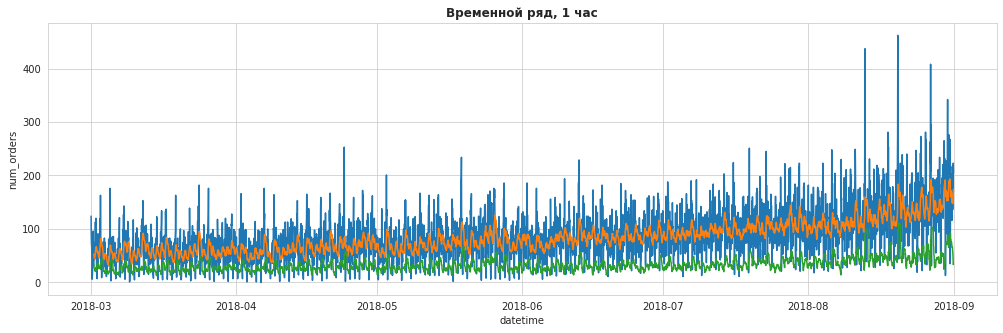

In [31]:
lineplot_helper(df_1h, df_1h, 'Временной ряд, 1 час', 2)

На первый взгляд ряд `стационарный`, проверим его при помощи теста `Дики-Фуллера`, при котором 0 гипотеза будет утверждать, что временной ряд является `нестационарным`. Если значение `p-value` будет более `0,05` и не будет близко к этому значению, то мы отвергнем 0 гипотезу.

In [32]:
st = adfuller(df_1h, regression='ctt')
print('p-value -', st[1])
print('Временной ряд стационарный' if st[1] < 0.05 else 'Временной ряд нестационарный')

p-value - 4.0549397892403547e-17
Временной ряд стационарный


## Анализ и подготовка данных

### Анализ временного ряда

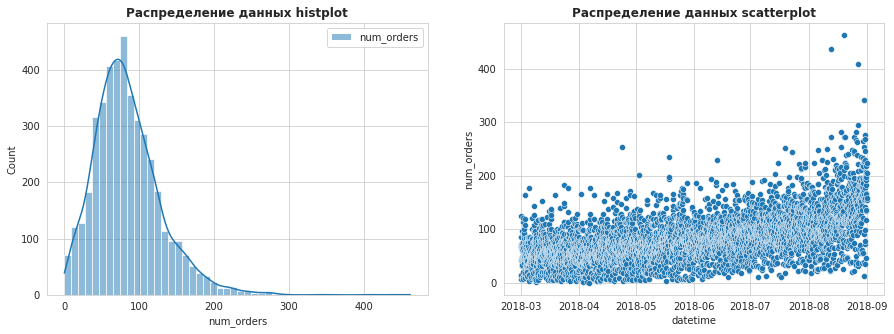

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.423,45.024,0.0,54.0,78.0,107.0,462.0


In [33]:
plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(df_1h, bins=50, kde=True)
plt.xlabel('num_orders')
plt.title('Распределение данных histplot', fontweight='bold')

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_1h.index, y = df_1h.num_orders)
plt.title('Распределение данных scatterplot', fontweight='bold')
plt.show()

display(df_1h.describe().T)

Временой ряд в большей степени однородный, распределение числа заказов нормальное, с "хвостом" в сторону увеличения. Общая тенденция направленна в сторону увеличения числа заказов от месяца к месяцу.   
Минимальное значение числа заказов - `0`, максимальной `462` заказа, в большинстве дней колчичество заказов в предалех `54 - 107` заказов.

Временной ряд располагается на графике линейно, с небольшими выбросами в течени выборки и с заметными выбросами в конце августа.

Построим коррелограмму для визуализации случайности в данных временного ряда.

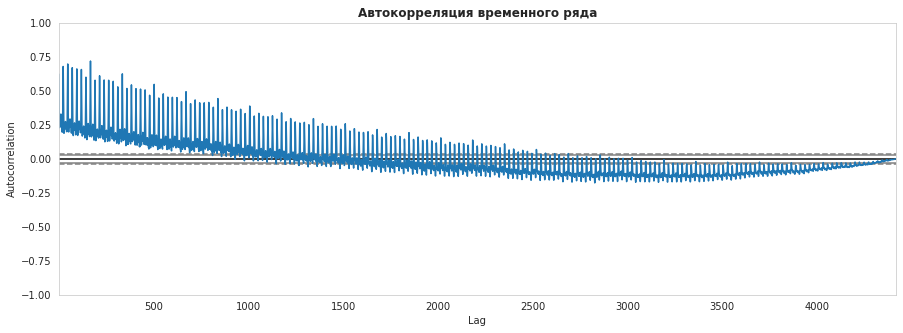

In [34]:
plt.subplots(figsize=(15,5))
pd.plotting.autocorrelation_plot(df_1h)
plt.title('Автокорреляция временного ряда', fontweight='bold')
plt.show()

Временой ряд монотонно возрастает, и явлется не случайным. В начале временого периода наблюдается сильная корреляция, которая по мере движения стремиться к 0 и переходит в отрицательную корреляцию, далее возращается к 0.

Расмотрим временной ряд в разрезе компонетнов: 

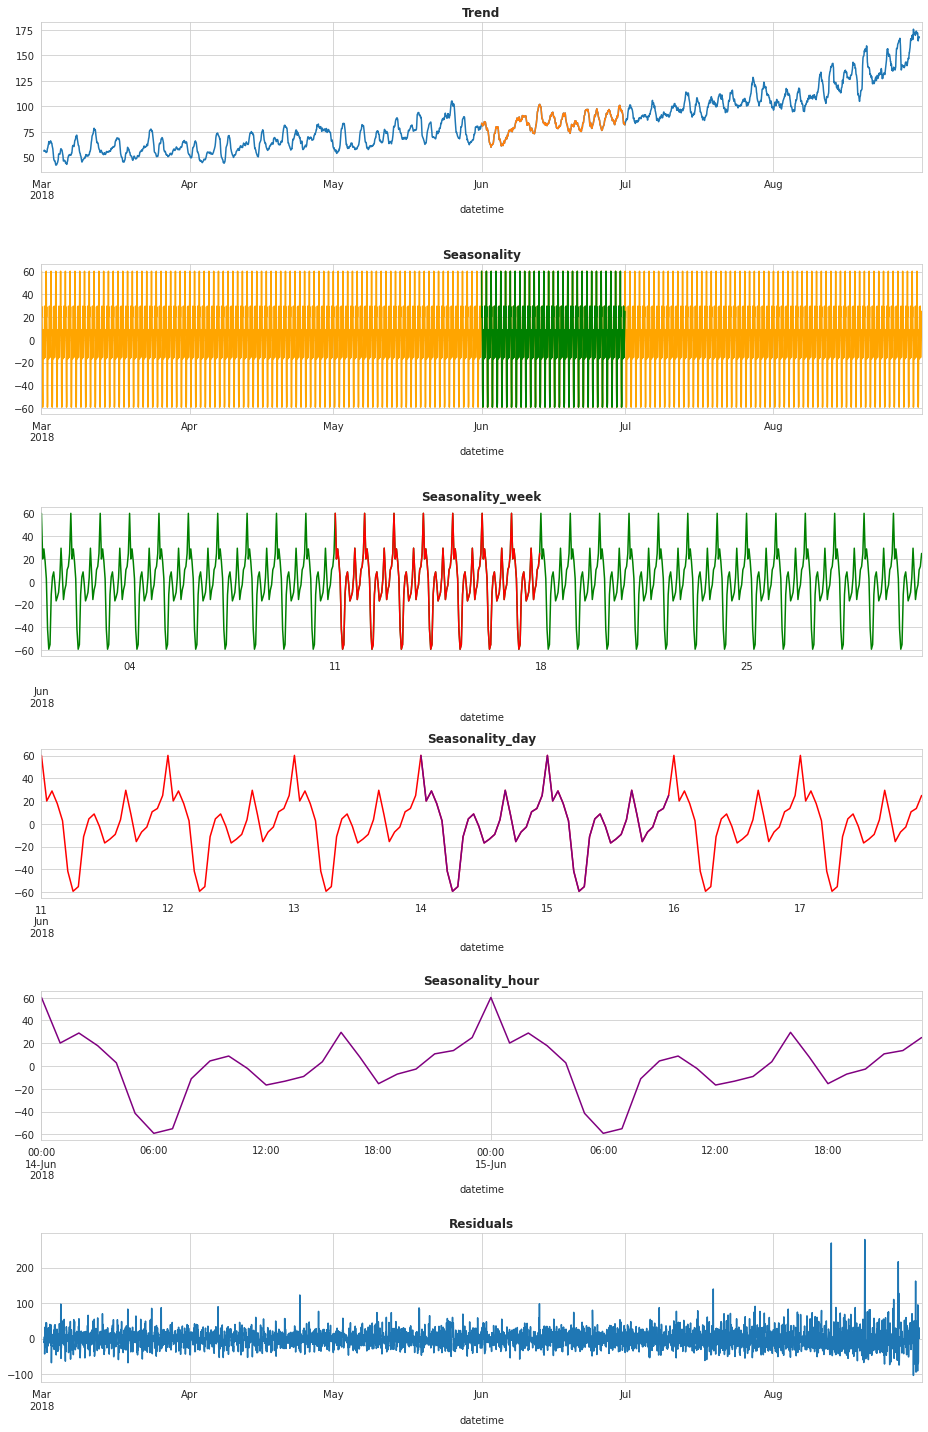

In [35]:
decomp = seasonal_decompose(df_1h)

plt.figure(figsize=(13, 20))
plt.grid()

plt.subplot(611)
decomp.trend.plot(ax=plt.gca())
decomp.trend['2018-06-01':'2018-06-30'].plot(ax=plt.gca())
plt.title('Trend', fontweight='bold')

plt.subplot(612)
decomp.seasonal.plot(ax=plt.gca(), color='orange')
decomp.seasonal['2018-06-01':'2018-06-30'].plot(ax=plt.gca(), color='green')
plt.title('Seasonality', fontweight='bold')

plt.subplot(613)
decomp.seasonal['2018-06-01':'2018-06-30'].plot(ax=plt.gca(), color='green')
decomp.seasonal['2018-06-11':'2018-06-17'].plot(ax=plt.gca(), color='red')
plt.title('Seasonality_week', fontweight='bold')

plt.subplot(614)
decomp.seasonal['2018-06-11':'2018-06-17'].plot(ax=plt.gca(), color='red')
decomp.seasonal['2018-06-14':'2018-06-15'].plot(ax=plt.gca(), color='purple')
plt.title('Seasonality_day', fontweight='bold')

plt.subplot(615)
decomp.seasonal['2018-06-14':'2018-06-15'].plot(ax=plt.gca(), color='purple')
plt.title('Seasonality_hour', fontweight='bold')

plt.subplot(616)
decomp.resid.plot(ax=plt.gca())
plt.title('Residuals', fontweight='bold')

plt.tight_layout()


На всей протежении выборки наблюдается тренд, который имеет восходящую тенденцию от начало и до конца выборки, что характеризуется увеличением числа заказов в день к концу выборки. 

Характер сезонной нагрузки показывает, что нагрузка не сильно зависит от дней недели, однако с увеличением масштаба наблюдаем увеличение числа заказов (тренд) от `06.00 до 00.00 часов` каждый день, что логично, с `00.00 до 06.00 часов` меньше рейсов.

Выборке наблюдаются шум, особенно во второй половине августа.

### Подготовка данных

Для обучения моделей данными временных рядов, необходимо будет добавить дополнительные признаки, который помогут качественному обучению моделей. Допонительные признаки будем получать из даты и значений временного ряда (скользящее среднее, предидущии значения (lag features)). А так же поделить выборку на `тестовую (10%)` и `тенировочную (90%)`

In [36]:
#добавление новых признаков
def add_features(df, max_lag, roll_mean):
    data = df.copy()

    for name in ['year', 'month', 'day', 'dayofweek']:
        data[name] = getattr(data.index, name)
        
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data.num_orders.shift(lag)

    data['rolling_mean'] = data.num_orders.shift().rolling(roll_mean).mean()

    return data

In [37]:
#поиск лучших признаков
def find_best_features(estimator, func, data, param_meaning, verbose=0):
    score_rsme = 10000
    lag = 0
    rolling_mean_size = 0
    samples_dict = dict()
    
    for i in param_meaning['lag']:
        for j in param_meaning['rolling_mean_size']:
            
            data_new = func(data, i, j)  
            data_new = data_new.dropna()

            feature = data_new.drop('num_orders', axis=1)
            target = data_new.num_orders
            
            X_train_all, X_test, y_train_all, y_test = train_test_split(feature, 
                                                                        target, 
                                                                        shuffle=False, 
                                                                        test_size=.1, 
                                                                        random_state=STATE)
            X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, 
                                                                  y_train_all, 
                                                                  shuffle=False, 
                                                                  test_size=.1, 
                                                                  random_state=STATE)
    
            model = estimator.fit(X_train, y_train) 
        
            predict = model.predict(X_valid)
            
            rsme = mean_squared_error(predict, y_valid) ** 0.5            
            if rsme < score_rsme:
                score_rsme = round(rsme, 3)
                lag = i
                rolling_mean_size = j
                samples_dict = dict(X_train_all = X_train_all, X_valid = X_valid,
                                    X_test = X_test, X_train = X_train, 
                                    y_train_all = y_train_all, y_test = y_test, 
                                    y_train = y_train, y_valid = y_valid) 
    
            if verbose == 1:
                print('RMSE -', rsme)
                print(f'lag = {i}, rolling_mean_size = {j}' )
                print('------------------------------------------------------------------------------------')
    

    print(f'lag = {lag}, rolling_mean_size = {rolling_mean_size}, rsme - {score_rsme}' )
    print('-------------------------------------------------------------------------------------------------')
    return samples_dict

In [38]:
samples_list=list()

In [39]:
%%time
param_meaning ={'lag' : [i for i in range(25, 31, 3)], 'rolling_mean_size' : [i for i in range(9, 21, 4)]}

samples_dict_lr = find_best_features(LinearRegression(), add_features, df_1h, param_meaning)
samples_list.append(samples_dict_lr)

lag = 28, rolling_mean_size = 17, rsme - 33.916
-------------------------------------------------------------------------------------------------
CPU times: user 391 ms, sys: 861 ms, total: 1.25 s
Wall time: 1.2 s


In [40]:
%%time
samples_dict_rfr = find_best_features(RandomForestRegressor(random_state=STATE), 
                                      add_features, df_1h, param_meaning)
samples_list.append(samples_dict_rfr)

lag = 28, rolling_mean_size = 9, rsme - 32.431
-------------------------------------------------------------------------------------------------
CPU times: user 27.3 s, sys: 51.7 ms, total: 27.4 s
Wall time: 27.4 s


In [41]:
%%time
samples_dict_cbr = find_best_features(CatBoostRegressor(verbose=0), add_features, df_1h, param_meaning)
samples_list.append(samples_dict_cbr)

lag = 28, rolling_mean_size = 17, rsme - 31.268
-------------------------------------------------------------------------------------------------
CPU times: user 34.8 s, sys: 569 ms, total: 35.4 s
Wall time: 40.2 s


In [42]:
%%time
samples_dict_knr = find_best_features(KNeighborsRegressor(), add_features, df_1h, param_meaning)
samples_list.append(samples_dict_knr)

lag = 28, rolling_mean_size = 13, rsme - 33.166
-------------------------------------------------------------------------------------------------
CPU times: user 480 ms, sys: 909 ms, total: 1.39 s
Wall time: 1.38 s


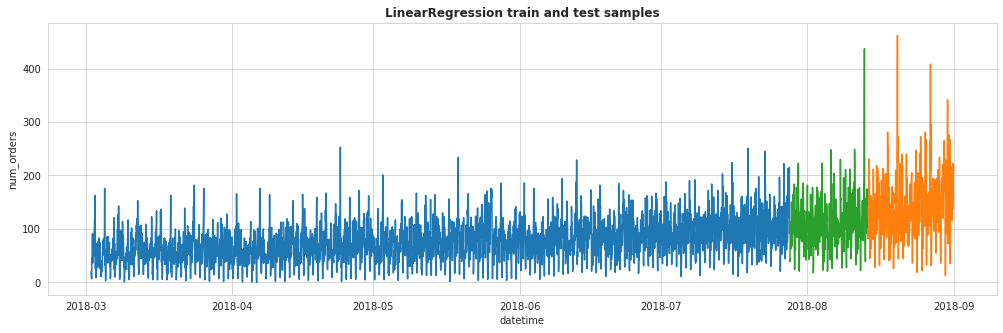

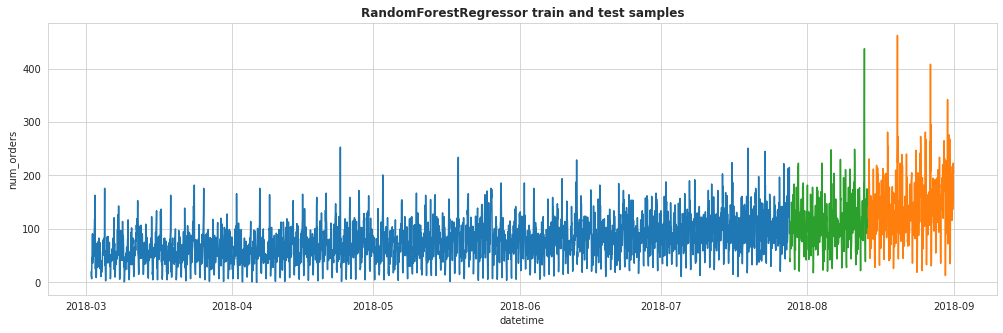

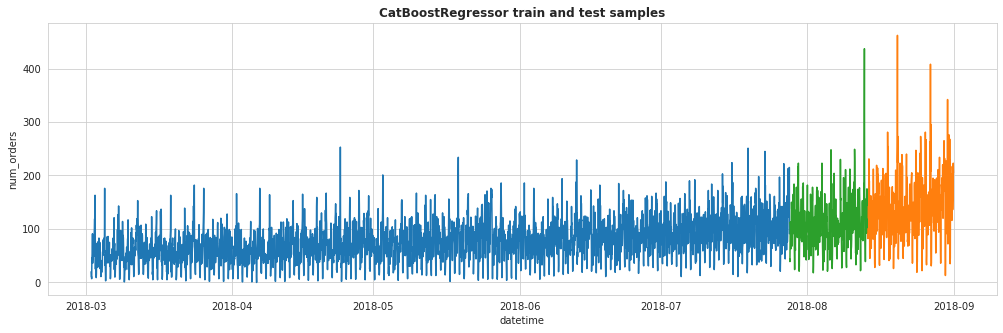

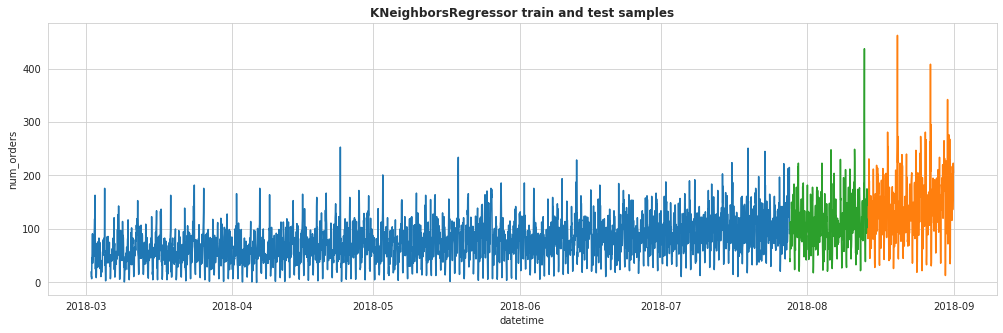

In [43]:
#проверим распределения выборок временного ряда
model_name_list = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'KNeighborsRegressor']
for i, sample in enumerate(samples_list):
    lineplot_helper(sample['y_train'], sample['y_test'], 
                    f'{model_name_list[i]} train and test samples', 3, sample['y_valid'])

## Обучение

In [58]:
#функция для получения модели
def find_model(regressor, samples_list, param={}):
    splits = TimeSeriesSplit(n_splits=3)
    clf = GridSearchCV(
        estimator= regressor, 
        param_grid = param, 
        cv = splits, 
        n_jobs=-1,
        scoring= 'neg_mean_squared_error')    
    
    clf.fit(samples_list['X_train'], samples_list['y_train'])
  
    #print(f'{regressor.__class__.__name__} best score RMSE -', round(-1 * clf.best_score_ ) ** 0.5, 3)
    print(f'{regressor.__class__.__name__} best param -', clf.best_params_)
    print('-------------------------------------------------------------------------------------------------')
    
    return clf.best_estimator_

In [59]:
#обучение и предсказие и получение время и оценки
def get_result(model, samples_list, key_X = 'X_valid', 
               key_y = 'y_valid', key_train = 'y_train', arima='none', ex_test=None):
    
    if arima == 'arimax':
        predicts = model.predict(
            len(samples_list[key_train]), 
            len(samples_list[key_train]) + len(samples_list[key_y]) - 1,
            exog=ex_test)
        
    elif arima == 'ar':
        predicts = model.predict(
            len(samples_list[key_train]), 
            len(samples_list[key_train]) + len(samples_list[key_y]) - 1)
    else:    
        predicts = model.predict(samples_list[key_X])
        predicts = pd.Series(predicts, index=samples_list[key_y].index)
              
    rsme = round(mean_squared_error(predicts, samples_list[key_y])**0.5, 2) 
    
    lineplot_helper(samples_list[key_train]['2018-08':], 
                    samples_list[key_y], 
                    f'test vs predict {model.__class__.__name__}', 
                    3, 
                    predicts)
    print(model.__class__.__name__, 'RSME -', rsme)
    return [model.__class__.__name__, rsme]
  

In [60]:
df_res = pd.DataFrame(columns=['model', 'rsme'])
display(df_res)

,model,rsme


Перед обученнением моделе получим оценку RSME на основании предсказания модели основанного на предыдущем шаге.

In [61]:
#оценка для сравнения с другими результатми
pred_previous = samples_dict_lr['y_test'].shift(fill_value=samples_dict_lr['y_train'].iloc[-1])
df_res.loc[df_res.shape[0]] = ['test RSME', round(mean_squared_error(pred_previous, samples_dict_lr['y_test']) ** 0.5, 3)]
display(df_res)

,model,rsme
0,test RSME,59.001


LinearRegression best param - {}
-------------------------------------------------------------------------------------------------


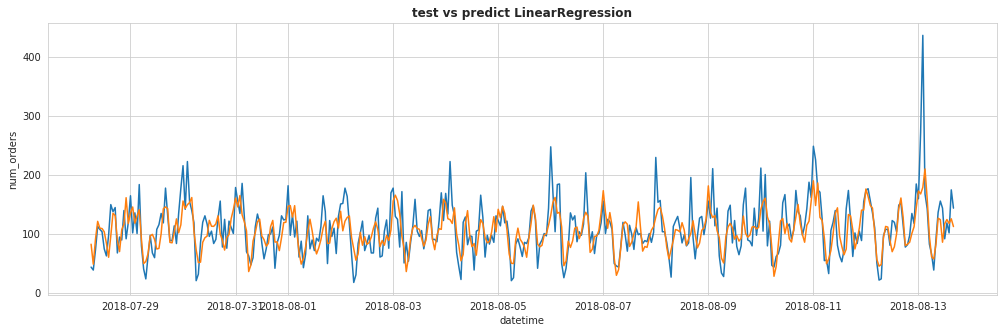

LinearRegression RSME - 33.92
CPU times: user 473 ms, sys: 423 ms, total: 896 ms
Wall time: 875 ms


In [62]:
%%time
model_lr = find_model(LinearRegression(), samples_dict_lr)
df_res.loc[df_res.shape[0]] = get_result(model_lr, samples_dict_lr)

RandomForestRegressor best param - {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100}
-------------------------------------------------------------------------------------------------


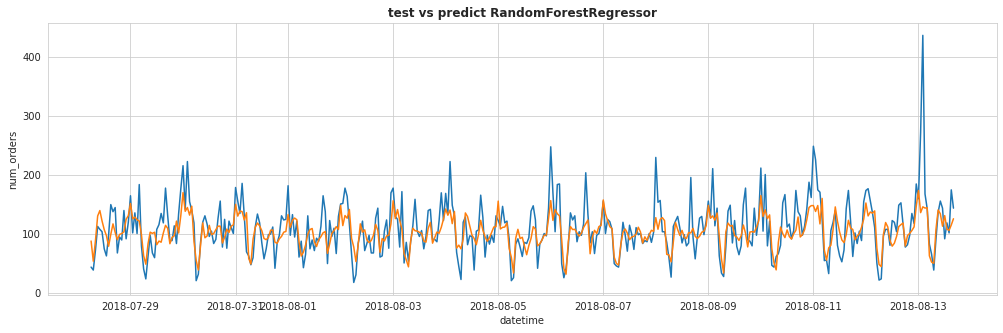

RandomForestRegressor RSME - 33.62
CPU times: user 50.1 s, sys: 425 ms, total: 50.6 s
Wall time: 50.7 s


In [63]:
%%time
forest_params = {
    'n_estimators': range(90, 115, 5),
    'max_depth' : range(4, 10, 2),
    'min_samples_leaf' : range(1, 2)  
}
model_rfr = find_model(RandomForestRegressor(random_state=STATE), samples_dict_rfr, forest_params)
df_res.loc[df_res.shape[0]] = get_result(model_rfr, samples_dict_rfr)

CatBoostRegressor best param - {'iterations': 1000, 'learning_rate': 0.5, 'max_depth': 7}
-------------------------------------------------------------------------------------------------


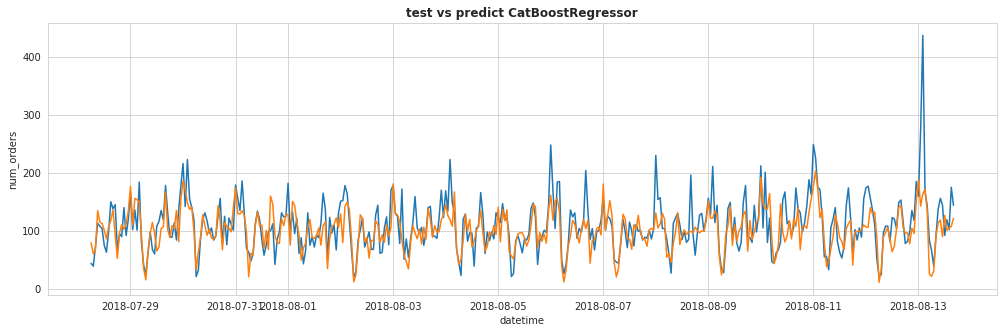

CatBoostRegressor RSME - 33.68
CPU times: user 2min 28s, sys: 3.82 s, total: 2min 31s
Wall time: 2min 53s


In [64]:
%%time
catboost_params = {
    'learning_rate': [0.5],
    'iterations': [980, 1000, 1010],
    'max_depth': [5, 6, 7]
}
model_cbr = find_model(CatBoostRegressor(verbose=0), samples_dict_cbr, catboost_params)
df_res.loc[df_res.shape[0]] = get_result(model_cbr, samples_dict_cbr)

KNeighborsRegressor best param - {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
-------------------------------------------------------------------------------------------------


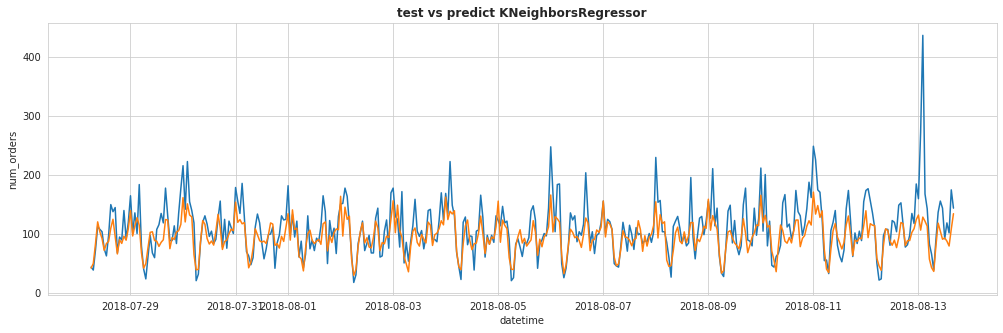

KNeighborsRegressor RSME - 33.38
CPU times: user 1.62 s, sys: 964 ms, total: 2.58 s
Wall time: 2.59 s


In [65]:
%%time
cnr_params = {'n_neighbors': [11, 12, 15], 
           'weights': ['distance'],
           'p':[1,2]}

model_cnr = find_model(KNeighborsRegressor(), samples_dict_knr, cnr_params)
df_res.loc[df_res.shape[0]] = get_result(model_cnr, samples_dict_knr)

Для сравнения обучим так же модели авторегресии (`AutoReg`) и `ARIMAX`. Для модели `ARIMAX`, будем использовать в качестве подкрепления `X_train из LinearRegression`, за исключением признаков сгенерированных из даты и нечетные лаги. 

In [66]:
#данные для ARIMAX
col_mask = [f'lag_{i}' for i in range(1, 26, 2)]
col_mask = ['rolling_mean', *col_mask]
df_test = samples_dict_lr['X_valid'][col_mask]
df_train = samples_dict_lr['X_train'][col_mask]

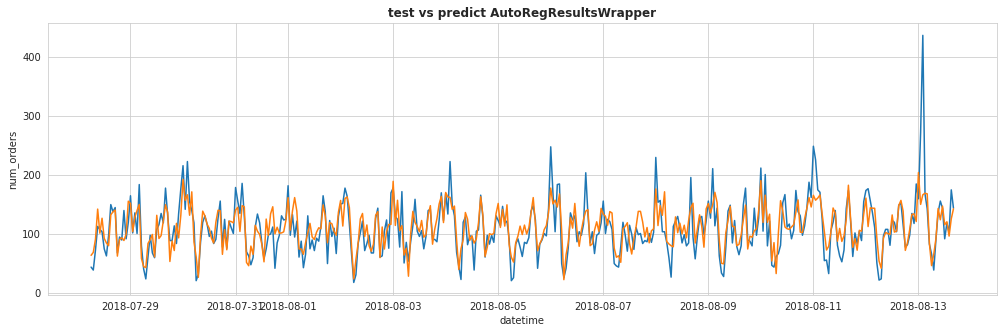

AutoRegResultsWrapper RSME - 29.77


In [67]:
#обучение AR
model_ar = AutoReg(samples_dict_lr['y_train'], lags=708).fit()
df_res.loc[df_res.shape[0]] = get_result(model_ar, samples_dict_lr, arima='ar')

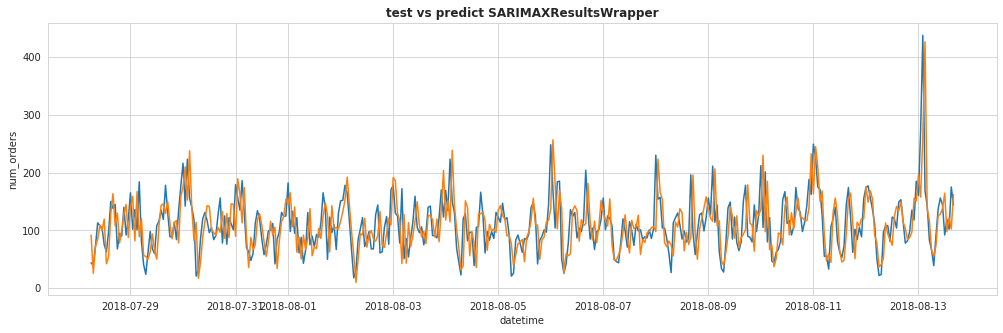

SARIMAXResultsWrapper RSME - 44.15


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                 3554
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -16625.667
Date:                Fri, 02 Dec 2022   AIC                          33287.335
Time:                        22:19:51   BIC                          33398.489
Sample:                    03-02-2018   HQIC                         33326.975
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
rolling_mean     0.3459      0.188      1.843      0.065      -0.022       0.714
lag_1            0.9800      0.027     36.052      0.000       0.927       1.033
lag_3           -0.0163      0.029     -0.553      0.580      -0.074       0.041
lag_5           -0.1400      0.028     -5.063      0.000      -0.194      -0.086
lag_7            0.0684      0.027      2.529      0.011       0.015       0.121
lag_9           -0.1179      0.027     -4.364      0.000      -0.171      -0.065
lag_11           0.0076      0.029      0.263      0.792      -0.049       0.064
lag_13          -0.0631      0.028     -2.270      0.023      -0.118      -0.009
lag_15          -0.0999      0.028     -3.531      0.000      -0.155      -0.044
lag_17           0.0337      0.023      1.453      0.146      -0.012       0.079
lag_19          -0.0749      0.017     -4.466      0.000      -0.108      -0.042
lag_21           0.0600      0.017      3.597      0.000       0.027       0.093
lag_23           0.3192      0.018     17.871      0.000       0.284       0.354
lag_25          -0.3024      0.011    -26.455      0.000      -0.325      -0.280
ar.L1            0.2044      0.027      7.545      0.000       0.151       0.258
ar.L2            0.1535      0.023      6.607      0.000       0.108       0.199
ma.L1           -0.9998      0.010   -104.306      0.000      -1.019      -0.981
sigma2         753.7631     17.874     42.172      0.000     718.731     788.795
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):               660.72
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

CPU times: user 21.7 s, sys: 54.7 s, total: 1min 16s
Wall time: 1min 16s


In [68]:
%%time
#обучение ARIMAX
model_sarimax = SARIMAX(samples_dict_lr['y_train'], 
                        order=(2, 0, 1), 
                        exog=df_train,
                        enforce_invertibility=False, 
                        enforce_stationarity=False).fit(disp=False)
df_res.loc[df_res.shape[0]] = get_result(model_sarimax, samples_dict_lr, arima='arimax', ex_test=df_test)
display(model_sarimax.summary())

In [69]:
display(df_res.sort_values('rsme'))

,model,rsme
5,AutoRegResultsWrapper,29.770
4,KNeighborsRegressor,33.380
2,RandomForestRegressor,33.620
3,CatBoostRegressor,33.680
1,LinearRegression,33.920
6,SARIMAXResultsWrapper,44.150
0,test RSME,59.001


Лучший результат показала Авторегрессия (*скорее всего sarimax показал бы лучший результат, но у меня не хатило знаний корректно его настроить*), обычные модели спавляются хуже, т.к. данный временной ряд имеет в конце очень не странные большие выбросы. 

## Тестирование

Протестируем лучшую модель на тестовых данных

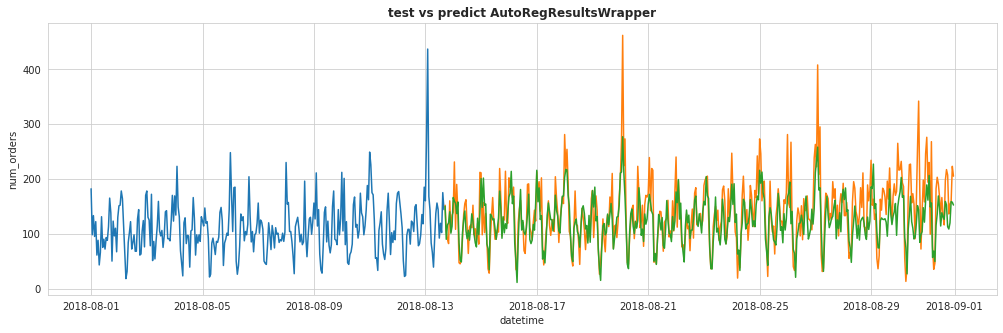

AutoRegResultsWrapper RSME - 40.05
CPU times: user 2.9 s, sys: 1.81 s, total: 4.71 s
Wall time: 4.72 s


In [70]:
%%time
model_ar = AutoReg(samples_dict_lr['y_train_all'], lags=708).fit()
_ = get_result(model_ar, 
               samples_dict_lr, 
               key_X='X_test', 
               key_y='y_test',
               key_train='y_train_all',
               arima='ar')

Из-за большого количества выбросов, модель предсказывает с чуть худшим качеством, но цель выполнена, RSME на тестовой выборке менее 48.

## Вывод

Лучший результат показала Авторегрессия (*скорее всего sarimax показал бы лучший результат, но у меня не хватило знаний корректно его настроить*), обычные модели спавляются хуже, т.к. данный временной ряд имеет в конце очень не странные большие выбросы. 

Данное исследование было реализовано, с целью предсказания пиковых нагрузок по историческим данным на основании лушей оценки rsme. 

Входные данные - данные содержит в себе временной ряд хранящий исторические данные с датой и временем  с `2018-03-01 00:00:00 - 2018-08-31 23:00:00` и количеством заказов на каждый интервал времени. Общее количество объектов - `26496`.  

**Цель проекта**
- Подготовить данные
- Провести анализ временного рядя
- Настроить и обучить разные модели.
- Протестировать модели на тестовой выборке и получить оценку `RSME` менее 48


**В ходе исследования:**
- Был изучен временной ряд, который оказался монотонно возрастающим, стационарным в интервале 1 час.
- Проведен анализ и обнаруженно, что в ряде есть тренд с интервало с `6.00 часов` до `00.00 часов` и с `00.00 часов` до `06.00 часов.`
- Были обнаружены значительные выбросы, в конце временного ряда, и которые попали в тестовую выборку, это усложнило задачу получения более низкой оценки `RSME`. 
- Было вычислены и добавлены в выборку новые признаки которые расчитывались на основании времнного лага и скользящей средней временного ряда.
- В ходе подбора дополнительных признаков была проведена оценка `RSME` на стандартных гипперпараметрах моделей, и полученны очень хорошре показатели.
- Были подобраны гипперпараметры для моделей на основании тренировочных данных для каждой модели с соотвествующей каждой модели количеством входных признаков.
- Было проведена оценка **6 моделей** на тестовых данных - `LinearRegression`, `RandomForestRegressor`, `KNeighborsRegressor`, `CatBoostRegressor`, `AutoReg`, `SARIMAX`.

**В итоге:**   

Лучшей по оценке `RSME` стала модель `AutoReg` с оценкой - `40.05`.  
Так же было выявленно , что на временной ряд гипперпараметры оказывают не такое сильное влияние как подбор количества входных признаков. Модели на стандартных гипперпараметрах показали так же хорошие результаты. Простая модель `LinearRegression`, показала результат не на много хуже, чем более сложные модели.  
Модели основанные на основе авторегрессионых и скользящих средних решений показывают очень хорошие результаты прогнозирования временного ряда. в т.ч. при отсутвии входных признаков. Однако данные модели сложны в настройки и сильно зависимы них.